# Loading libraries

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import re
warnings.filterwarnings('ignore')

# Loading data

In [55]:
# === Load preselected SNP data === #
data_snp = pd.read_csv("C:/Users/bciez/Documents/Basilio/Columbia_University/MLdosage/PRADI/SNP_coding_chr1_chr22_onehot.csv")  # Replace with your full merged dataset if needed
print(data_snp.shape)
data_snp.head()

(511, 505)


,chr1:63043840:AG:A_A_0,chr1:63043840:AG:A_A_1,chr1:63043840:AG:A_A_2,chr2:109640281:G:A_A_0,chr2:109640281:G:A_A_1,chr2:109640281:G:A_A_2,chr2:111695715:C:T_T_0,chr2:111695715:C:T_T_1,chr2:111695715:C:T_T_2,chr2:111703717:G:A_A_0,...,chr20:8823625:G:A_A_1,chr20:8823625:G:A_A_2,chr20:17888796:G:T_T_0,chr20:17888796:G:T_T_1,chr20:24136062:T:G_T_0,chr20:24136062:T:G_T_1,chr20:24136062:T:G_T_2,chr22:48531736:T:C_T_0,chr22:48531736:T:C_T_1,chr22:48531736:T:C_T_2
0,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,True,False,False,True,False,False,True,False,False,True,...,True,False,True,False,True,False,False,False,True,False
2,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,True,False,False
4,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False


In [56]:
# === Load preselected SNP data === #
data_pheno = pd.read_csv("C:/Users/bciez/Documents/Basilio/Columbia_University/MLdosage/PRADI/pheno_oct2022_filtered_PC",sep="\t")  # Replace with your full merged dataset if needed
print(data_pheno.shape)
data_pheno.head()

(511, 10)


,FID,IID,SEX,APOE4,AGE,ADRD_FINAL,PC1,PC2,PC3,PC4
0,CWR_6021,CWR_6021_1,2,2.0,65,1,-0.0260,0.0660,0.0681,-0.0103
1,CWR_6053,CWR_6053_1,1,0.0,87,1,0.0226,0.0006,0.0115,0.0238
2,CWR_6060,CWR_6060_1,2,0.0,61,0,-0.0166,-0.0130,0.0561,0.0143
3,IHG_87236,IHG_87236_1,2,0.0,82,1,NaN,NaN,NaN,0.0035
4,IHG_87500,IHG_87500_1,2,0.0,77,1,-0.0208,-0.0030,0.0132,0.0288


In [57]:
data = pd.concat([data_pheno, data_snp], axis=1)
data_clean = data.dropna()
data = data_clean.copy()
data

,FID,IID,SEX,APOE4,AGE,ADRD_FINAL,PC1,PC2,PC3,PC4,...,chr20:8823625:G:A_A_1,chr20:8823625:G:A_A_2,chr20:17888796:G:T_T_0,chr20:17888796:G:T_T_1,chr20:24136062:T:G_T_0,chr20:24136062:T:G_T_1,chr20:24136062:T:G_T_2,chr22:48531736:T:C_T_0,chr22:48531736:T:C_T_1,chr22:48531736:T:C_T_2
0,CWR_6021,CWR_6021_1,2,2.0,65,1,-0.0260,0.0660,0.0681,-0.0103,...,False,False,True,False,False,False,True,False,True,False
1,CWR_6053,CWR_6053_1,1,0.0,87,1,0.0226,0.0006,0.0115,0.0238,...,True,False,True,False,True,False,False,False,True,False
2,CWR_6060,CWR_6060_1,2,0.0,61,0,-0.0166,-0.0130,0.0561,0.0143,...,False,False,True,False,True,False,False,True,False,False
4,IHG_87500,IHG_87500_1,2,0.0,77,1,-0.0208,-0.0030,0.0132,0.0288,...,False,False,True,False,True,False,False,True,False,False
5,IHG_87504,IHG_87504_1,2,1.0,70,1,0.0858,0.0055,0.0092,-0.0060,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,IHG_88412,IHG_88412_1,2,0.0,74,1,-0.0162,-0.0016,0.0396,-0.0478,...,False,False,True,False,False,True,False,False,True,False
507,IHG_88413,IHG_88413_1,2,0.0,92,0,0.0819,-0.0385,0.0166,-0.0029,...,False,False,True,False,True,False,False,True,False,False
508,IHG_88415,IHG_88415_1,2,0.0,80,0,-0.0016,0.0117,-0.0053,-0.0063,...,False,False,True,False,True,False,False,True,False,False
509,IHG_88416,IHG_88416_1,2,0.0,83,0,-0.0254,0.0383,0.0326,-0.0056,...,False,False,True,False,False,True,False,True,False,False


In [58]:
# === Define features and target === #
data.rename(columns={'ADRD_FINAL': 'ADRD'}, inplace=True)
data.rename(columns={'APOEe4': 'APOE4'}, inplace=True)
X = data.drop(columns=["FID","IID","AGE","SEX","APOE4","ADRD","PC1","PC2","PC3","PC4"])  # Replace 'ADRD_FINAL' with your phenotype column
y = data["ADRD"]

In [59]:
X.head()

,chr1:63043840:AG:A_A_0,chr1:63043840:AG:A_A_1,chr1:63043840:AG:A_A_2,chr2:109640281:G:A_A_0,chr2:109640281:G:A_A_1,chr2:109640281:G:A_A_2,chr2:111695715:C:T_T_0,chr2:111695715:C:T_T_1,chr2:111695715:C:T_T_2,chr2:111703717:G:A_A_0,...,chr20:8823625:G:A_A_1,chr20:8823625:G:A_A_2,chr20:17888796:G:T_T_0,chr20:17888796:G:T_T_1,chr20:24136062:T:G_T_0,chr20:24136062:T:G_T_1,chr20:24136062:T:G_T_2,chr22:48531736:T:C_T_0,chr22:48531736:T:C_T_1,chr22:48531736:T:C_T_2
0,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,True,False,False,True,False,False,True,False,False,True,...,True,False,True,False,True,False,False,False,True,False
2,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
4,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
5,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,False,True


In [60]:
y.head()

0    1
1    1
2    0
4    1
5    1
Name: ADRD, dtype: int64

# Split data

In [61]:
# Check for NaNs or infinite values
print("NaNs in X:", X.isnull().sum().sum())
print("NaNs in y:", y.isnull().sum())
print("Infinite values in X:", np.isinf(X).sum().sum())


# Option 2 (alternative): Fill NaNs (optional)
# X = X.fillna(0)

# Check again
print("After cleaning - NaNs in X:", X.isnull().sum().sum())
print("After cleaning - NaNs in y:", y.isnull().sum())


NaNs in X: 0
NaNs in y: 0
Infinite values in X: 0
After cleaning - NaNs in X: 0
After cleaning - NaNs in y: 0


In [62]:
data_clean = data.dropna()
data = data_clean.copy()
# Sanitize column names
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

In [63]:
X

,chr1_63043840_AG_A_A_0,chr1_63043840_AG_A_A_1,chr1_63043840_AG_A_A_2,chr2_109640281_G_A_A_0,chr2_109640281_G_A_A_1,chr2_109640281_G_A_A_2,chr2_111695715_C_T_T_0,chr2_111695715_C_T_T_1,chr2_111695715_C_T_T_2,chr2_111703717_G_A_A_0,...,chr20_8823625_G_A_A_1,chr20_8823625_G_A_A_2,chr20_17888796_G_T_T_0,chr20_17888796_G_T_T_1,chr20_24136062_T_G_T_0,chr20_24136062_T_G_T_1,chr20_24136062_T_G_T_2,chr22_48531736_T_C_T_0,chr22_48531736_T_C_T_1,chr22_48531736_T_C_T_2
0,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,True,False,False,True,False,False,True,False,False,True,...,True,False,True,False,True,False,False,False,True,False
2,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
4,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
5,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,False
507,False,True,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
508,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
509,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,True,False,False


In [64]:
y

0      1
1      1
2      0
4      1
5      1
      ..
506    1
507    0
508    0
509    0
510    0
Name: ADRD, Length: 509, dtype: int64

In [65]:
# === Split data === #
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train


,chr1_63043840_AG_A_A_0,chr1_63043840_AG_A_A_1,chr1_63043840_AG_A_A_2,chr2_109640281_G_A_A_0,chr2_109640281_G_A_A_1,chr2_109640281_G_A_A_2,chr2_111695715_C_T_T_0,chr2_111695715_C_T_T_1,chr2_111695715_C_T_T_2,chr2_111703717_G_A_A_0,...,chr20_8823625_G_A_A_1,chr20_8823625_G_A_A_2,chr20_17888796_G_T_T_0,chr20_17888796_G_T_T_1,chr20_24136062_T_G_T_0,chr20_24136062_T_G_T_1,chr20_24136062_T_G_T_2,chr22_48531736_T_C_T_0,chr22_48531736_T_C_T_1,chr22_48531736_T_C_T_2
115,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,True,False
196,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,True,False,False
425,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,True,False,False
466,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
277,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,True
256,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,True,False
208,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,True,False,False
451,False,False,True,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False


# Logistic Regression Models

In [66]:
# === Logistic Regression Models === #
models = {
    "Logistic_Lasso": LogisticRegression(penalty='l1', solver='saga', max_iter=1000),
    "Logistic_Ridge": LogisticRegression(penalty='l2', solver='saga', max_iter=1000),
    "Logistic_ElasticNet": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)
}

# Fitting


🔎 Performing cross-validation for Logistic_Lasso...
✅ Best hyperparameters for Logistic_Lasso: {'C': 10, 'penalty': 'l1'}


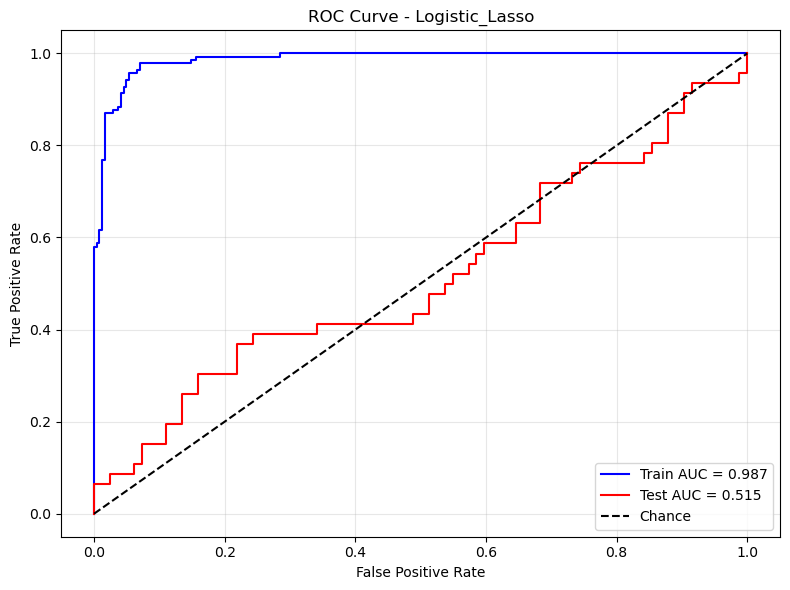

📊 Logistic_Lasso - Train AUC: 0.9866 | Test AUC: 0.5151

🔎 Performing cross-validation for Logistic_Ridge...
✅ Best hyperparameters for Logistic_Ridge: {'C': 10, 'penalty': 'l2'}


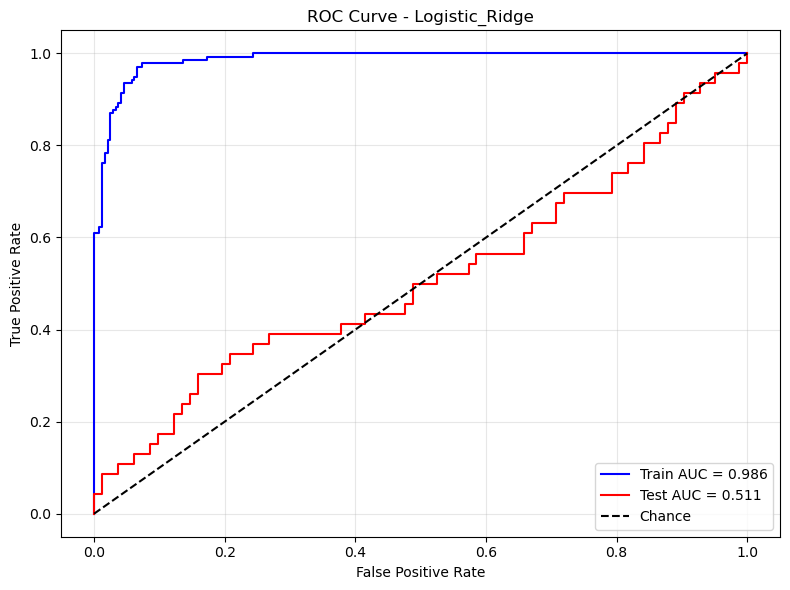

📊 Logistic_Ridge - Train AUC: 0.9864 | Test AUC: 0.5111

🔎 Performing cross-validation for Logistic_ElasticNet...
✅ Best hyperparameters for Logistic_ElasticNet: {'C': 10, 'penalty': 'elasticnet'}


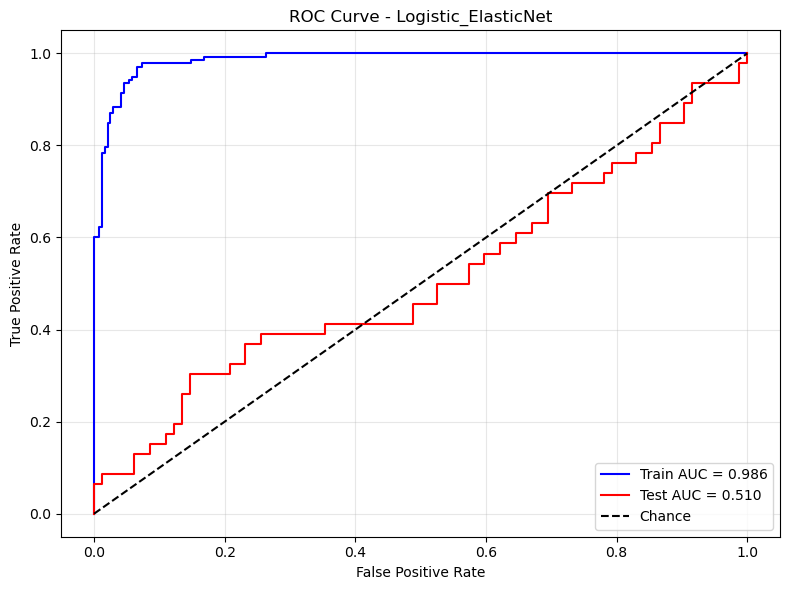

📊 Logistic_ElasticNet - Train AUC: 0.9865 | Test AUC: 0.5098

🔎 Performing cross-validation for XGBoost...
✅ Best hyperparameters for XGBoost: {'learning_rate': 0.01, 'n_estimators': 100}


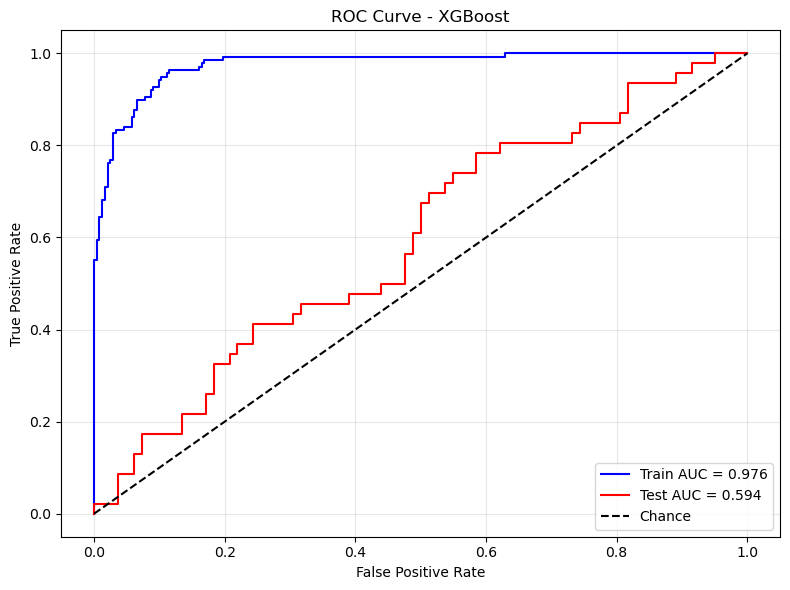

📊 XGBoost - Train AUC: 0.9756 | Test AUC: 0.5938

🔎 Performing cross-validation for LightGBM...
[LightGBM] [Info] Number of positive: 138, number of negative: 243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 381, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362205 -> initscore=-0.565808
[LightGBM] [Info] Start training from score -0.565808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

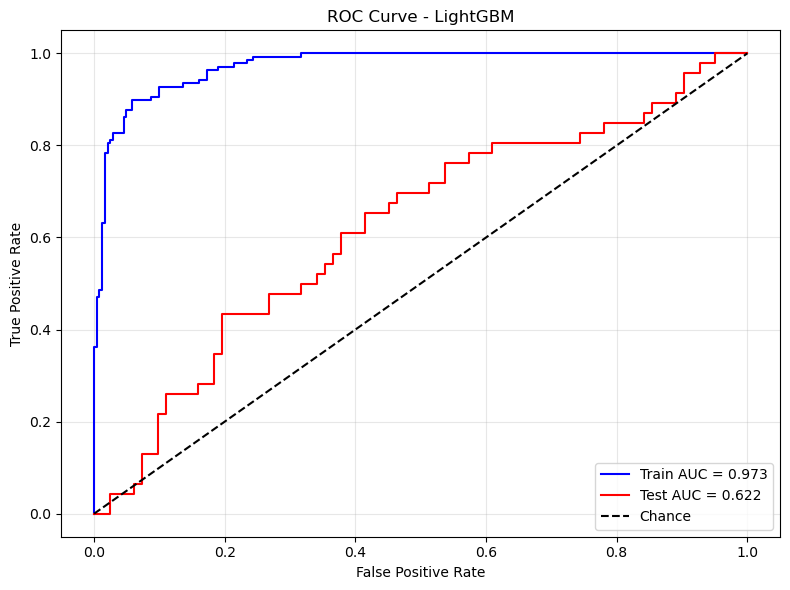

📊 LightGBM - Train AUC: 0.9731 | Test AUC: 0.6217

🔎 Performing cross-validation for CatBoost...
✅ Best hyperparameters for CatBoost: {'depth': 4, 'learning_rate': 0.01}


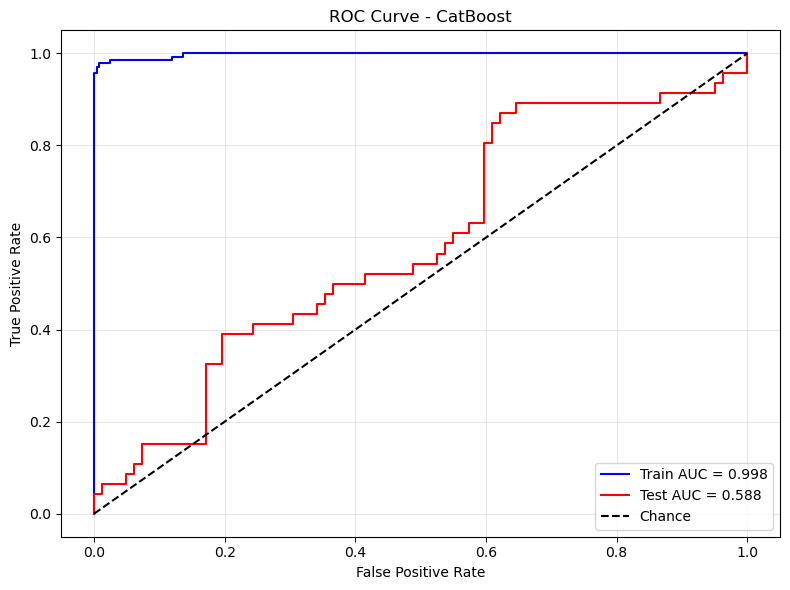

📊 CatBoost - Train AUC: 0.9979 | Test AUC: 0.5878

🔎 Performing cross-validation for NeuralNetwork...
✅ Best hyperparameters for NeuralNetwork: {'hidden_layer_sizes': (50,)}


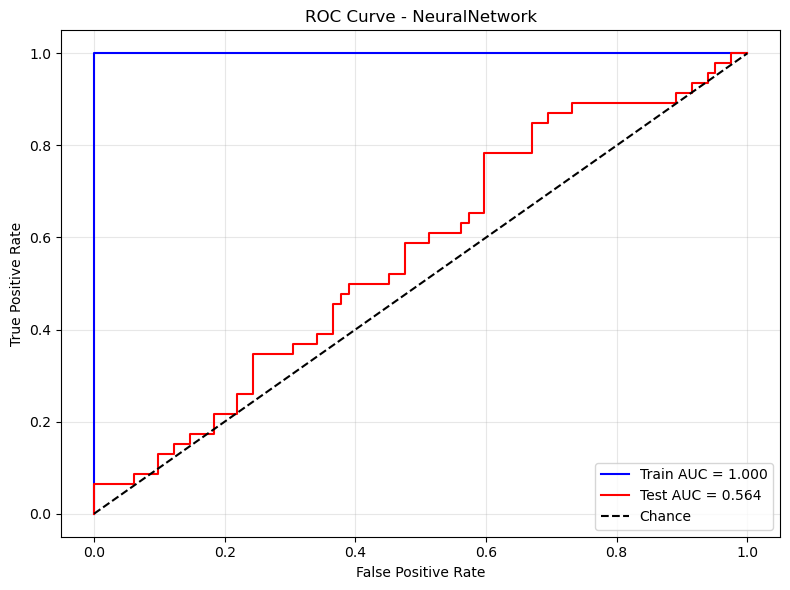

📊 NeuralNetwork - Train AUC: 1.0000 | Test AUC: 0.5644


In [67]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

'''
# === Load and clean data === #
data = pd.read_csv("SNP_preselected_chr22.csv")
data_clean = data.dropna()
X = data_clean.drop(columns=["IID", "ADRD"])
y = data_clean["ADRD"]

# Sanitize feature names
X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

'''

# === Define models and hyperparameter grids === #
param_grids = {
    "Logistic_Lasso": {
        "model": LogisticRegression(solver='saga', max_iter=1000),
        "params": {"penalty": ["l1"], "C": [0.01, 0.1, 1, 10]}
    },
    "Logistic_Ridge": {
        "model": LogisticRegression(solver='saga', max_iter=1000),
        "params": {"penalty": ["l2"], "C": [0.01, 0.1, 1, 10]}
    },
    "Logistic_ElasticNet": {
        "model": LogisticRegression(solver='saga', max_iter=1000, l1_ratio=0.5),
        "params": {"penalty": ["elasticnet"], "C": [0.01, 0.1, 1, 10]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {"depth": [4, 6, 8], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "NeuralNetwork": {
        "model": MLPClassifier(max_iter=500),
        "params": {"hidden_layer_sizes": [(50,), (100,), (100, 50)]}
    }
}

# === Cross-validation setup === #
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Train, evaluate, and plot ROC curves === #
for name, config in param_grids.items():
    print(f"\n🔎 Performing cross-validation for {name}...")
    
    grid_search = GridSearchCV(
        config["model"], config["params"], cv=cv, scoring='roc_auc', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)  # Cross-validation on training set
    best_model = grid_search.best_estimator_  # Select best model from CV
    
    print(f"✅ Best hyperparameters for {name}: {grid_search.best_params_}")

    # Predict probabilities using the best model
    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict_proba(X_test)[:, 1]

    # AUC scores
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", color='blue')
    plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", color='red')
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"../output/plots/ROC_{name}_WithCV.png")
    plt.show()

    print(f"📊 {name} - Train AUC: {auc_train:.4f} | Test AUC: {auc_test:.4f}")


# Evaluation of feature importance

In [68]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [69]:
X

,chr1_63043840_AG_A_A_0,chr1_63043840_AG_A_A_1,chr1_63043840_AG_A_A_2,chr2_109640281_G_A_A_0,chr2_109640281_G_A_A_1,chr2_109640281_G_A_A_2,chr2_111695715_C_T_T_0,chr2_111695715_C_T_T_1,chr2_111695715_C_T_T_2,chr2_111703717_G_A_A_0,...,chr20_8823625_G_A_A_1,chr20_8823625_G_A_A_2,chr20_17888796_G_T_T_0,chr20_17888796_G_T_T_1,chr20_24136062_T_G_T_0,chr20_24136062_T_G_T_1,chr20_24136062_T_G_T_2,chr22_48531736_T_C_T_0,chr22_48531736_T_C_T_1,chr22_48531736_T_C_T_2
0,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
1,True,False,False,True,False,False,True,False,False,True,...,True,False,True,False,True,False,False,False,True,False
2,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
4,False,True,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,True,False,False
5,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,False,True,False
507,False,True,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
508,False,True,False,False,True,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
509,True,False,False,True,False,False,True,False,False,True,...,False,False,True,False,False,True,False,True,False,False



Evaluating Logistic_Lasso...


Mean ROC-AUC: 0.5194 ± 0.0204


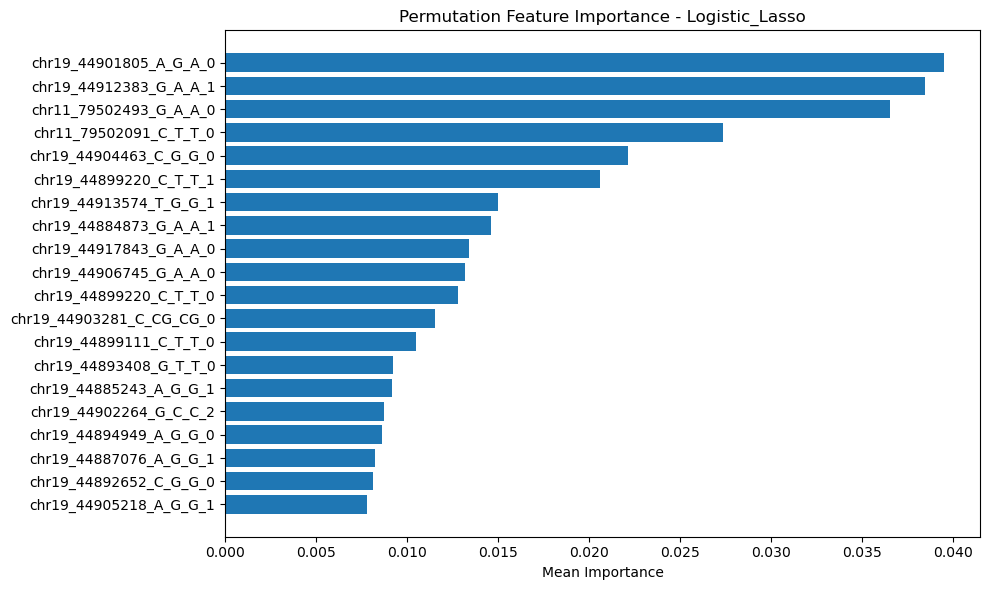


Evaluating Logistic_Ridge...
Mean ROC-AUC: 0.5213 ± 0.0175


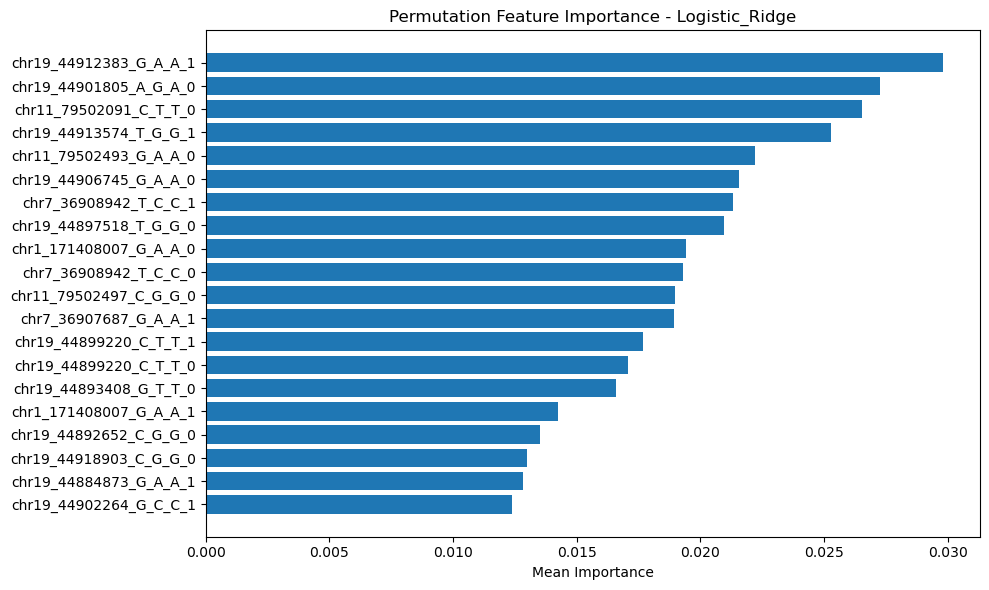


Evaluating Logistic_ElasticNet...
Mean ROC-AUC: 0.5210 ± 0.0191


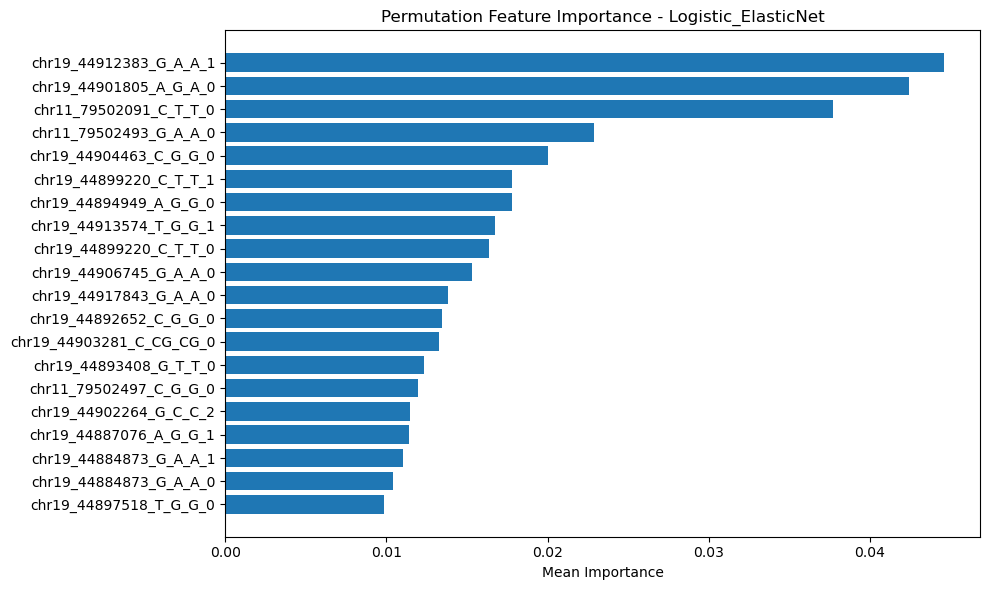


Evaluating XGBoost...
Mean ROC-AUC: 0.5212 ± 0.0319


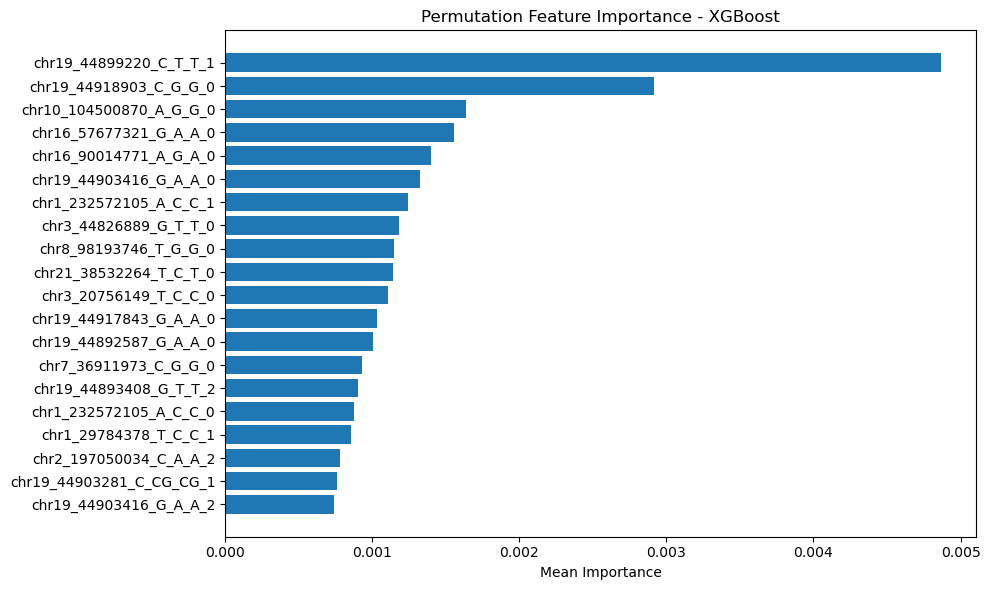


Evaluating LightGBM...
Mean ROC-AUC: 0.5266 ± 0.0319
[LightGBM] [Info] Number of positive: 860, number of negative: 1749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2609, number of used features: 380
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329628 -> initscore=-0.709867
[LightGBM] [Info] Start training from score -0.709867


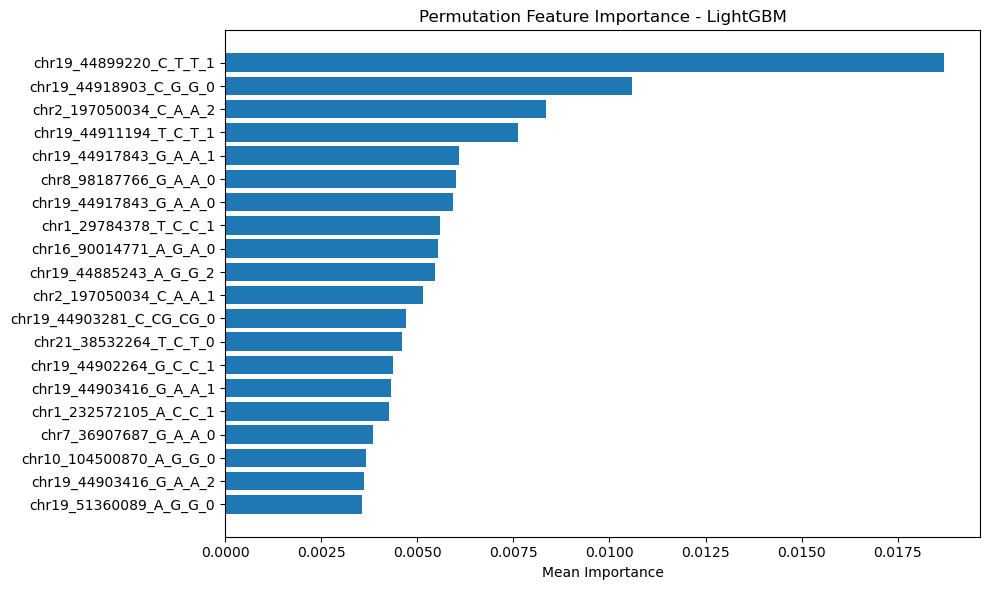


Evaluating CatBoost...
Mean ROC-AUC: 0.5277 ± 0.0272


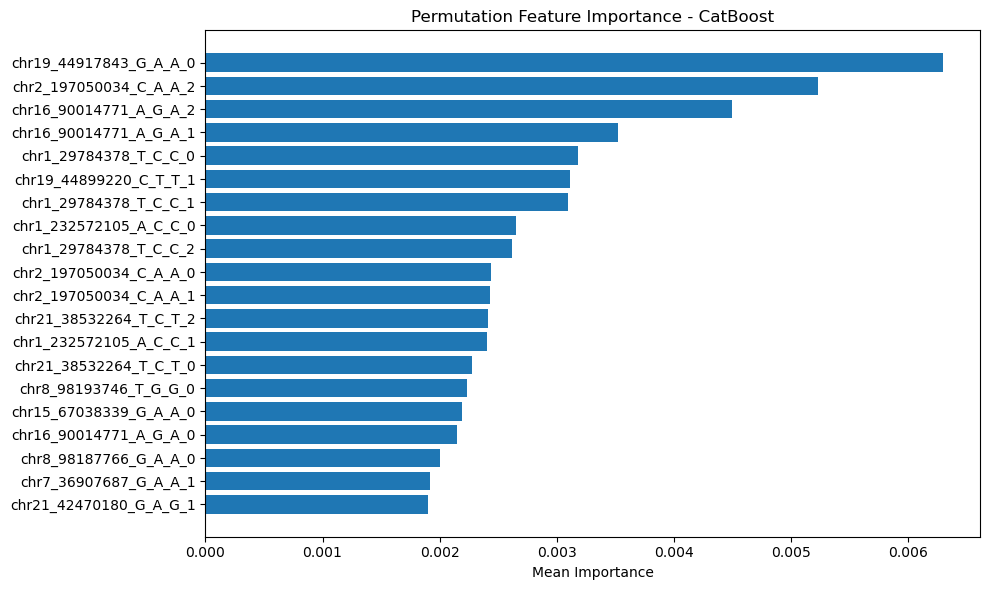


Evaluating NeuralNetwork...
Mean ROC-AUC: 0.5167 ± 0.0351


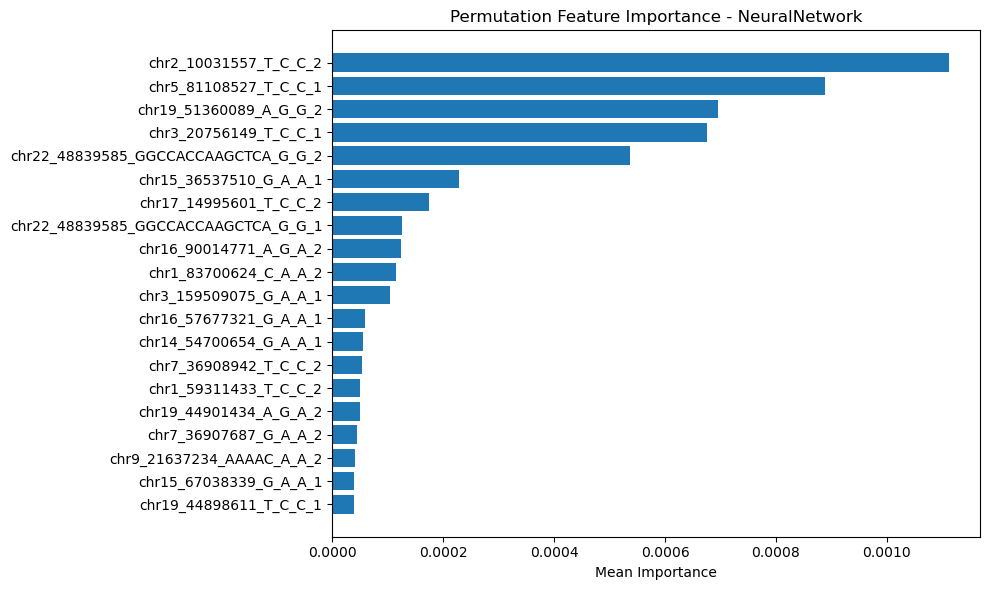

In [51]:
# === Cross-validation setup === #
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Evaluate models === #
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Cross-validated ROC-AUC
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"Mean ROC-AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
    
    # Fit the model on the full dataset to get feature importance
    model.fit(X, y)
    
    # Permutation Feature Importance (PFI)
    result = permutation_importance(model, X, y, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    }).sort_values(by='Importance', ascending=False)
    
    # Save feature importance
    importance_df.to_csv(f"PFI_{name}.csv", index=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
    plt.xlabel('Mean Importance')
    plt.title(f'Permutation Feature Importance - {name}')
    plt.tight_layout()
    plt.savefig(f"PFI_{name}.png")
    plt.show()